In [1]:
# Importing libraries
import argparse
import re
import os
import random
from glob import glob
import io

from datasets import load_metric
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
from setproctitle import setproctitle
from tqdm import tqdm

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer,T5TokenizerFast, T5ForConditionalGeneration

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, EarlyStoppingCallback


# for kobert
# from kobert_tokenizer import KoBERTTokenizer
# from transformers import BertModel

import torch
import difflib as dl

import nltk
# nltk.download('punkt')
import string
from transformers import AutoTokenizer

parser = argparse.ArgumentParser()
# parser.add_argument('--dataset_path', default='/gec/data/v1.0/clean_data_v2_utf8.tsv')
# parser.add_argument('--dataset_path', default='/home/gec_sj/gec/data/v1.0/Korean_corpus_2021.csv')
# parser.add_argument('--north_phonetic_data_v1_path', default='/home/gec_sj/gec/data/v1.0/north_phonetic_corpus_v1.tsv')
# parser.add_argument('--north_phonetic_data_v2_path', default='/home/gec_sj/gec/data/v1.0/north_phonetic_corpus_v2.tsv')
# parser.add_argument('--modu_spelling_data_path', default='/home/gec_sj/gec/data/v1.0/modu_spelling_corpus_2021.tsv')
# parser.add_argument('--kspon_spelling_data_path', default='/home/gec_sj/gec/data/v1.0/kspon_spelling_corpus.tsv')

parser.add_argument('--dataset_format', default='tsv')
# parser.add_argument('--pretrained_model', default='KETI-AIR/ke-t5-large')
# parser.add_argument('--pretrained_model', default='KETI-AIR/ke-t5-large-ko')

parser.add_argument('--pretrained_model', default='paust/pko-t5-base')
# parser.add_argument('--pretrained_model', default="google/flan-t5-base")

# parser.add_argument('--pretrained_model', default='skt/kobert-base-v1')
# parser.add_argument('--pretrained_model', default='google/mt5-large')


parser.add_argument('--seed', default=68)
parser.add_argument('--process_name', default='64pko-t5-mario')
parser.add_argument('--batch_size', default=4)
parser.add_argument('--devices', default='2,3')
parser.add_argument('--data_limit', default=False)
parser.add_argument('--test_size_ratio', default=0.01)
# parser.add_argument('--output_dir', default="./pko_save/")
parser.add_argument('--output_dir', default="./pko_save/pko-len64/")

parser.add_argument('--max_input_length', default=64) # 96
parser.add_argument('--min_input_length', default=5)
parser.add_argument('--max_target_length', default=64)
parser.add_argument('--min_target_length', default=5)

args = parser.parse_args(args=[])

random.seed(args.seed)

os.environ["WANDB_DISABLED"] = "true"

setproctitle(args.process_name)
## cuda device 설정
os.environ["CUDA_VISIBLE_DEVICES"]= args.devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)  # 출력결과: cuda 
print('Count of using GPUs:', torch.cuda.device_count())   #출력결과: 2 (2, 3 두개 사용하므로)
print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)

2022-11-14 13:52:36.211907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 13:52:36.405731: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 13:52:37.286681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-14 13:52:37.286790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

Device: cuda
Count of using GPUs: 2
Current cuda device: 0


In [2]:
path = '/gec_s/s-kr/fine-tune/dataset/gec_dataset'

file_list=glob(os.path.join(path, '*.tsv'))
df32=pd.DataFrame(list())
for path_file in tqdm(file_list):
    s_df = pd.read_csv(path_file, sep='\t', encoding='utf-8',index_col='Unnamed: 0', error_bad_lines=False, engine='python')
    df32=pd.concat([df32, s_df])
    
df=df32.reset_index()
df=df[['form','corrected_form']]
df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
df=df.sample(n=520000, replace=False) # 전체 60만개에서 52만개만 무작위로 가져옴
df['form'][:50000]=df.corrected_form[:50000] # 정상-정상비율 //그중 30만개는 input과 output이 같은걸로 세팅
df=pd.DataFrame(df)

# 

100%|█████████████████████████████████████████████████████| 62/62 [00:06<00:00,  9.61it/s]


In [3]:
len(df)

520000

In [4]:
df['form'] = df['form'].apply(lambda x: str(x).strip())
df['corrected_form'] = df['corrected_form'].apply(lambda x: str(x).strip())


In [5]:
# 정상-정상 갯수
df[df['form']==df['corrected_form']].count() # 311912 

form              75173
corrected_form    75173
dtype: int64

In [6]:
# for i in df['corrected_form']:
#     print(i)

In [7]:
# regex = r'[^%!?~,.a-zA-Z0-9가-힣\s+]'
regex = r'[^가-힣.,?\s+]' # 포함할것

In [8]:
df['form'] = df['form'].apply(lambda x: re.sub(regex, '', x))
df['corrected_form'] = df['corrected_form'].apply(lambda x: re.sub(regex, '', x))

df['form'] = df['form'].apply(lambda x: x.strip())
df['corrected_form'] = df['corrected_form'].apply(lambda x: x.strip())

trgs = ['\xa0', '\\xa0', u'\xa0', u'\u200a', u'\u3000', '+']
def rm_trgs(x):
    for trg in trgs:
        if trg in x:
            x = x.replace(trg, '')
    return x

df['form'] = df['form'].apply(rm_trgs)
df['corrected_form'] = df['corrected_form'].apply(rm_trgs)


#불필요 공백, 특수문자 처리
def clean_space(x):
    x = re.sub(r'\n+\t+', ' ', x)
    x = re.sub(r'\s+', ' ', x) #remove extra space
    x = x.strip()
    # x = re.sub(r'^\s+', '', x) #remove space from start
    # x = re.sub(r'\s+$', '', x) #remove space from the end
    return x

df['form'] = df['form'].apply(clean_space)
df['corrected_form'] = df['corrected_form'].apply(clean_space)

fn_df = df[df.form.apply(lambda x: args.min_input_length < len(x) <= args.max_input_length)]
fn_df = df[df.corrected_form.apply(lambda x: args.min_target_length < len(x) <= args.max_target_length)]

In [9]:
fn_df.head()

form  \
165705                                             새디스트야?   
181152  모르겠어 너무 막장으로만 골라서 하는 거 같애. 요즘 그런 거 볼 때마다 생각이 너...   
154017      동대문? 동대문 지금은 뭐 근데 그럼 뭐 좋은데는 못 가겠네. 막 너가 생각하는.   
169189           안 친하 그니까 되게 애매하지. 아직도 존댓말 쓰고 있잖아. 그래서 그냥   
348905                                       음 알겠어 알겠어. 야   

                                           corrected_form  
165705                                             새디스트야?  
181152  모르겠어 너무 막장으로만 골라서 하는 거 같애. 요즘 그런 거 볼 때마다 생각이 너...  
154017      동대문? 동대문 지금은 뭐 근데 그럼 뭐 좋은데는 못 가겠네. 막 너가 생각하는.  
169189           안 친하 그니까 되게 애매하지. 아직도 존댓말 쓰고 있잖아. 그래서 그냥  
348905                                       음 알겠어 알겠어. 야

In [10]:
fn_df['mean_len']=list(map(lambda x:len(x), fn_df['form']))
fn_df.head()

/tmp/ipykernel_95/2993394619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_df['mean_len']=list(map(lambda x:len(x), fn_df['form']))


form  \
165705                                             새디스트야?   
181152  모르겠어 너무 막장으로만 골라서 하는 거 같애. 요즘 그런 거 볼 때마다 생각이 너...   
154017      동대문? 동대문 지금은 뭐 근데 그럼 뭐 좋은데는 못 가겠네. 막 너가 생각하는.   
169189           안 친하 그니까 되게 애매하지. 아직도 존댓말 쓰고 있잖아. 그래서 그냥   
348905                                       음 알겠어 알겠어. 야   

                                           corrected_form  mean_len  
165705                                             새디스트야?         6  
181152  모르겠어 너무 막장으로만 골라서 하는 거 같애. 요즘 그런 거 볼 때마다 생각이 너...        57  
154017      동대문? 동대문 지금은 뭐 근데 그럼 뭐 좋은데는 못 가겠네. 막 너가 생각하는.        45  
169189           안 친하 그니까 되게 애매하지. 아직도 존댓말 쓰고 있잖아. 그래서 그냥        40  
348905                                       음 알겠어 알겠어. 야        12

총 데이터 수량 :  412020
평균길이 :  24.441136352604243


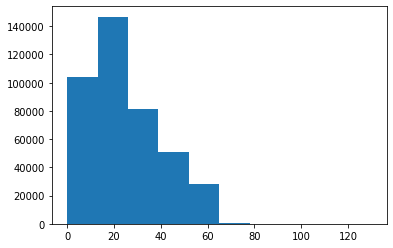

In [11]:
import matplotlib.pyplot as plt
print("총 데이터 수량 : ",fn_df['mean_len'].count())
print("평균길이 : ",fn_df['mean_len'].mean())

plt.hist(fn_df['mean_len'].tolist())
plt.show()

In [12]:
# fn_df['form']='수정할 문장 : '+fn_df['form']

In [13]:
fn_df.head(10)

form  \
165705                                             새디스트야?   
181152  모르겠어 너무 막장으로만 골라서 하는 거 같애. 요즘 그런 거 볼 때마다 생각이 너...   
154017      동대문? 동대문 지금은 뭐 근데 그럼 뭐 좋은데는 못 가겠네. 막 너가 생각하는.   
169189           안 친하 그니까 되게 애매하지. 아직도 존댓말 쓰고 있잖아. 그래서 그냥   
348905                                       음 알겠어 알겠어. 야   
233720                        남자들 말하는 거야? 아님, 여자들 말하는 거야?   
409189                                           연예인 많은 거   
408150                                            네. 없어요.   
386319                                       응. 나 재주 있잖아.   
349969  으 줄넘긴 내 누구한테 추천은 안 하는데 인라인은 진짜 해도 괜찮겠어. 돈도 이만 ...   

                                           corrected_form  mean_len  
165705                                             새디스트야?         6  
181152  모르겠어 너무 막장으로만 골라서 하는 거 같애. 요즘 그런 거 볼 때마다 생각이 너...        57  
154017      동대문? 동대문 지금은 뭐 근데 그럼 뭐 좋은데는 못 가겠네. 막 너가 생각하는.        45  
169189           안 친하 그니까 되게 애매하지. 아직도 존댓말 쓰고 있잖아. 그래서 그냥        40  
348905                                       음 알겠어 알겠어. 야        12  
233720                        남자들 말하는 거야? 아님, 여자들 말하는 거야?        27  
409189                                           연예인 많은 거         8  
408150                                            네. 없어요.         7  
386319                                       응. 나 재주 있잖아.        12  
349969  으 줄넘긴 내 누구한테 추천은 안 하는데 인라인은 진짜 해도 괜찮겠어. 돈도 이만 ...        56

In [14]:
# 14미만인건 따로 빼서 나중에 concat 시키자# ngram 도입

In [15]:
# infer_text_smal=list(map(lambda x:len(x.split(' '))<14, fn_df.form))
# infer_text_smal[:5]

In [16]:
#fn_df[len(fn_df.form) < 14 ]

In [17]:
len(fn_df)

412020

In [18]:
fn_df.shape

(412020, 3)

In [19]:
vocab = []
for i, row in tqdm(fn_df.iterrows(), total=df.shape[0]):
    form = row['form']
    corrected_form = row['corrected_form']
#     if '.' in form:
#         print(form)
#     elif '.' in corrected_form:
#         print(corrected_form)
    
#     if ',' in form:
#         print(form)
#     elif ',' in corrected_form:
#         print(corrected_form)
    # # '+' 확인
    # if '+' in form:
    #     print(form)
    # if '+' in corrected_form:
    #     print(corrected_form)
    # 개행문자 확인
#     if '\n' in form:
#         print(i, 'form', form)
#         print(i, 'corrected_form', corrected_form)
#         print('=' * 10)
        
#     if '\n' in form:
#         print(i, 'form', form)
#         print(i, 'corrected_form', corrected_form)
#         print('=' * 10)

    # 이상한애들 있는지 없는지
    # for trg in nfkd_target:
    #     if trg in form:
    #         # form = unicodedata.normalize('NFKD', form)
    #         form = form.replace(trg, '')
    #     elif trg in corrected_form:
    #         # corrected_form = unicodedata.normalize('NFKD', corrected_form_vocab)
    #         corrected_form = corrected_form.replace(trg, '')
    for char in form:
        vocab.append(char)
    for char in corrected_form:
        vocab.append(char)

vocab = sorted(set(vocab))

 79%|██████████████████████████████████         | 412020/520000 [01:05<00:17, 6271.05it/s]


In [20]:
print(vocab)

[' ', ',', '.', '?', '가', '각', '간', '갇', '갈', '갉', '감', '갑', '값', '갓', '갔', '강', '갖', '같', '갚', '갛', '개', '객', '갠', '갤', '갬', '갭', '갯', '갰', '갱', '갸', '갹', '걀', '걉', '걋', '걍', '걔', '걘', '걜', '걧', '거', '걱', '건', '걷', '걸', '검', '겁', '것', '겄', '겅', '겉', '겋', '게', '겐', '겔', '겜', '겝', '겟', '겠', '겡', '겨', '격', '겪', '견', '결', '겸', '겹', '겼', '경', '곁', '계', '곈', '곌', '곗', '곘', '고', '곡', '곤', '곧', '골', '곪', '곯', '곰', '곱', '곳', '공', '곶', '과', '곽', '관', '괄', '괌', '괍', '광', '괘', '괜', '괭', '괴', '굉', '교', '굑', '굔', '굘', '굣', '굥', '구', '국', '군', '굳', '굴', '굵', '굶', '굼', '굽', '굿', '궁', '궂', '궈', '권', '궐', '궜', '궝', '궤', '귀', '귄', '귈', '귐', '귓', '규', '균', '귤', '귯', '그', '극', '근', '귿', '글', '긁', '긃', '금', '급', '긋', '긌', '긍', '기', '긱', '긴', '길', '김', '깁', '깃', '깄', '깅', '깊', '까', '깍', '깎', '깐', '깔', '깜', '깝', '깞', '깟', '깠', '깡', '깥', '깨', '깬', '깰', '깸', '깻', '깼', '깽', '꺄', '꺅', '꺠', '꺤', '꺼', '꺽', '꺾', '껀', '껄', '껌', '껍', '껏', '껐', '껑', '께', '껜', '껨', '껴', '껸', '꼄', '꼇', '꼈', '꼐', '꼬', '꼭', '꼰', '꼳', '꼴',

In [21]:
raw_datasets = Dataset.from_pandas(fn_df).shuffle()

In [22]:
raw_datasets

Dataset({
    features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
    num_rows: 412020
})

In [23]:
medium_datasets = DatasetDict()
medium_datasets['train'] = raw_datasets

In [24]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
        num_rows: 412020
    })
})

In [25]:
# medium_datasets = medium_datasets.remove_columns('__index_level_0__')

In [26]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
        num_rows: 412020
    })
})

In [27]:
# datasets_train_test = medium_datasets["train"].train_test_split(test_size=int(args.test_size_ratio * len(df)))
# datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=int(args.test_size_ratio * len(df)))

# medium_datasets["train"] = datasets_train_validation["train"]
# medium_datasets["validation"] = datasets_train_validation["test"]
# medium_datasets["test"] = datasets_train_test["test"]

In [28]:
datasets_train_test = medium_datasets["train"].train_test_split(test_size=int(args.test_size_ratio * len(df)))

In [29]:
medium_datasets["train"] = datasets_train_test["train"]
medium_datasets["validation"] = datasets_train_test["test"]

In [30]:
medium_datasets["train"] = medium_datasets["train"].shuffle()
medium_datasets["validation"] = medium_datasets["validation"].shuffle()
# medium_datasets["test"] = medium_datasets["test"].shuffle()

In [31]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
        num_rows: 406820
    })
    validation: Dataset({
        features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
        num_rows: 5200
    })
})

In [32]:
model_checkpoint = args.pretrained_model



tokenizer = T5TokenizerFast.from_pretrained(model_checkpoint)
# model = T5ForConditionalGeneration.from_pretrained('paust/pko-t5-base')

# input_ids = tokenizer(["qa question: 당신의 이름은 무엇인가요?"]).input_ids
# labels = tokenizer(["T5 입니다."]).input_ids
# outputs = model(input_ids=input_ids, labels=labels)

# print(f"loss={outputs.loss} logits={outputs.logits}")

# model_checkpoint = "t5-base"
# tokenizer = KoBERTTokenizer.from_pretrained(model_checkpoint)
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# tokenizer = T5Tokenizer.from_pretrained(model_checkpoint) # 구글꺼도 이거 쓰면됨.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
# tokens = tokenizer.tokenize("T5 GEC 모델 파인튜닝 합니다.")
# print(tokens)

# tokenizer.convert_tokens_to_ids(tokens)

In [34]:
# medium_datasets_cleaned = medium_datasets.filter(
#     lambda example: (len(example['form']) > 5) and
#     (len(example['corrected_form']) > 5)
# )

medium_datasets_cleaned = medium_datasets

In [35]:
medium_datasets_cleaned

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
        num_rows: 406820
    })
    validation: Dataset({
        features: ['form', 'corrected_form', 'mean_len', '__index_level_0__'],
        num_rows: 5200
    })
})

In [36]:
def clean_text(text):
    # punctuation(문장부호 or 구두점)을 기준으로 개행
    # 즉, 한 문장 당 한 라인에 배치하도록 정제 하는 과정
    sentences = nltk.sent_tokenize(text.strip())
    sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
    sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
    text_cleaned = "\n".join(sentences_cleaned_no_titles)
    return text_cleaned

def preprocess_data(examples):
    # texts_cleaned = [clean_text(text) for text in examples["form"]]
    texts_cleaned = [text for text in examples["form"]]
    # inputs = [prefix + text for text in texts_cleaned]
    inputs = [text for text in texts_cleaned]
    
    model_inputs = tokenizer(inputs, max_length=args.max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["corrected_form"], max_length=args.max_target_length, 
                           truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [37]:
tokenized_datasets = medium_datasets_cleaned.map(preprocess_data,
                                                 batched=True)

  0%|          | 0/407 [00:00<?, ?ba/s]

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3542: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?ba/s]

In [38]:
tokenized_datasets['train']['form'][:2]

['뭐환경오염이야 그래서 개보단 고양이가 좋아', '어떻게 좋은 말인데 무슨 뜻이야']

In [39]:
tokenized_datasets['train']['corrected_form'][:2]

['환경오염이야 그래서 개보단 고양이가 좋아.', '어 되게 좋은 말인데 무슨 뜻이야?']

In [40]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [41]:
# metric = load_metric("rouge")
cer_metric = load_metric("cer")

In [42]:
'''
-100을 pad_token_id로 바꾸고 id를 디코딩하여 인코딩된 레이블을 원래 문자열로 다시 변환한다.
그리고 동시에 연속적인 토큰이 CTC 스타일의 동일한 토큰으로 그룹화되지 않도록 한다.
'''
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    # decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
    #                   for pred in decoded_preds]
    # print('decoded_preds:', decoded_preds[:5])
    # decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
    #                   for label in decoded_labels]
    # print('decoded_labels:', decoded_labels[:5])
    for pred, label in zip(decoded_preds, decoded_labels):
        print('_pred:', pred)
        print('label:', label)
        print('=' * 80)
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    # wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}
    # return {"wer": wer}

In [43]:
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
#     # Replace -100 in the labels as we can't decode them.
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
#     # Rouge expects a newline after each sentence
#     decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
#                       for pred in decoded_preds]
#     decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
#                       for label in decoded_labels]
    
#     # Compute ROUGE scores
#     result = metric.compute(predictions=decoded_preds, references=decoded_labels,
#                             use_stemmer=True)

#     # Extract ROUGE f1 scores
#     result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
#     # Add mean generated length to metrics
#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
#                       for pred in predictions]
#     result["gen_len"] = np.mean(prediction_lens)
    
#     return {k: round(v, 4) for k, v in result.items()}

In [44]:
# import wandb

# wandb.login()
# wandb.init(project='t5-north-ft')

In [45]:
# model_name = "t5-base-medium-title-generation"
model_dir = args.output_dir
number = 2000

training_args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=number,
    # eval_steps=5,
    logging_strategy="steps",
    logging_steps=number,
    save_strategy="steps",
    save_steps=number,
    # save_steps=5,
    # learning_rate=4e-8,
    learning_rate=4e-5,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.batch_size,
    weight_decay=0.01,
    num_train_epochs=100, # 3에서 1로 수정
    predict_with_generate=True,
    # fp16=True,
    save_total_limit=10,
    # eval_accumulation_steps=1,
    warmup_steps=number,
    load_best_model_at_end=True,
    # metric_for_best_model="rouge1",
    # report_to="wandb"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [46]:
# Function that returns an untrained model to be trained
def model_init():
    return T5ForConditionalGeneration.from_pretrained(model_checkpoint) #  device_map="auto" 이거추가하면 토치 1.9가 필요한듭
    # return T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")
    # return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
    # return BertModel.from_pretrained(model_checkpoint)


trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)],
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--paust--pko-t5-base/snapshots/90c817cd0e37b5cebf0a5869187e30b9998b82ef/config.json
Model config T5Config {
  "_name_or_path": "./models/pko-t5/base/checkpoint-810000",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "use_cache": true,
  "vocab_size": 50358
}

loading weights file py

In [47]:
torch.__version__

'1.7.0'

In [ ]:
trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--paust--pko-t5-base/snapshots/90c817cd0e37b5cebf0a5869187e30b9998b82ef/config.json
Model config T5Config {
  "_name_or_path": "./models/pko-t5/base/checkpoint-810000",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "use_cache": true,
  "vocab_size": 50358
}

loading weights file py

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form, mean_len, __index_level_0__. If form, corrected_form, mean_len, __index_level_0__ are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5200
  Batch size = 8


_pred: 음 뭔지 알겠어. 약간 오렌지 코라 이런 거.
label: 음 음 뭔지 알겠어. 약간 오렌지 코랄 이런 거?
_pred: 그냥 취미야. 엄마도 누워서 게임하잖아.
label: 음 그냥 취미야 엄마두 누워서 게임 하잖아.
_pred: 금 이번 계기로 친해지는 거 어때?
label: 금 이번 계기로 친해지는 거 어때?
_pred: 먹고 싶은 거 의견 실험해가지고 고기 어 고기를 
label: 먹고 싶은 거 의견 수렴해가지구 고기 어 고기를 많이 나왔는데
_pred: 아 여기까지 밀고 여기 머리 이렇게 된 거
label: 아 여기까지 밀고 여기 머리 이렇게 된 거?
_pred: 그때 우리 애들 하 코우가 부츠 사는 애 한
label: 그때 우리 애들 하 코우가부츠 사는 애 한 명도 없었는데 지태가 신문물 전파했었다고
_pred: 당샐러드야 그냥 근데 그게 만대가 너무 쉬워. 그래서
label: 당근 샐러드야 그냥, 근데 그게 만들기가 너무 쉬워. 그래서 내가 찾아봤더니 사람들이 그걸 엄청 많이 먹더라고.
_pred: 나 안 뺏어 피는데?
label: 나 안 뺏어 피는데?
_pred: 매직을 했었는데 나는 일주일만에 다 풀리더라고 왜냐면 내가
label: 매직을 했었는데, 나는 일주일 만에 다 풀리드라고. 왜냐면 내가 원래.
_pred: 그까 지연이 정도는 아니라 지원이보다 더 심한 
label: 까 지현이정돈 아니야. 지현이보다 더 심한 애들 있어. 내가 그런 애들. 군대에서 봤어가지고.
_pred: 그 같이 노래 부르면서 영화 보는 거?
label: 그 같이 노래 부르면서 영화 보는거.
_pred: 생각 없이 보는 건 아니지. 오락은 또 아니야. 
label: 생각 없이 보는 건 아니지. 오락은 또 아니야, 내가 코미디 이런 건 보는 건 아니잖아. 그런 게 좋아. 어.
_pred: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
label: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
_pred: 그러깐 잠은 어떡하지?
label: 그러니깐 자면 어떡

Saving model checkpoint to ./pko_save/pko-len64/checkpoint-2000
Configuration saved in ./pko_save/pko-len64/checkpoint-2000/config.json
Model weights saved in ./pko_save/pko-len64/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-len64/checkpoint-2000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-len64/checkpoint-2000/special_tokens_map.json
Deleting older checkpoint [pko_save/pko-len64/checkpoint-98000] due to args.save_total_limit
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form, mean_len, __index_level_0__. If form, corrected_form, mean_len, __index_lev

_pred: 음 뭔지 알겠어. 약간 오렌지 코라 이런 거.
label: 음 음 뭔지 알겠어. 약간 오렌지 코랄 이런 거?
_pred: 그냥 취미야. 엄마도 누워서 게임하잖아.
label: 음 그냥 취미야 엄마두 누워서 게임 하잖아.
_pred: 금 이번 계기로 친해지는 거 어때?
label: 금 이번 계기로 친해지는 거 어때?
_pred: 먹고 싶은 거 의견 실험해가지고 고기 어 고기를 
label: 먹고 싶은 거 의견 수렴해가지구 고기 어 고기를 많이 나왔는데
_pred: 아 여기까지 밀고 여기 머리 이렇게 된 거?
label: 아 여기까지 밀고 여기 머리 이렇게 된 거?
_pred: 그때 우리 애들 하 코우가 부츠 사는 애 한
label: 그때 우리 애들 하 코우가부츠 사는 애 한 명도 없었는데 지태가 신문물 전파했었다고
_pred: 당샐러드야. 그냥 근데 그게 만대가 너무 쉬워. 
label: 당근 샐러드야 그냥, 근데 그게 만들기가 너무 쉬워. 그래서 내가 찾아봤더니 사람들이 그걸 엄청 많이 먹더라고.
_pred: 나 안 뺏어 피는데.
label: 나 안 뺏어 피는데?
_pred: 매직을 했었는데 나는 일주일만에 다 풀리더라고 왜냐면 내가
label: 매직을 했었는데, 나는 일주일 만에 다 풀리드라고. 왜냐면 내가 원래.
_pred: 그까 지연이 정도는 아니라 지원이보다 더 심한 
label: 까 지현이정돈 아니야. 지현이보다 더 심한 애들 있어. 내가 그런 애들. 군대에서 봤어가지고.
_pred: 그 같이 노래 부르면서 영화 보는 거?
label: 그 같이 노래 부르면서 영화 보는거.
_pred: 생각 없이 보는 건 아니지. 오락은 또 아니야. 
label: 생각 없이 보는 건 아니지. 오락은 또 아니야, 내가 코미디 이런 건 보는 건 아니잖아. 그런 게 좋아. 어.
_pred: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
label: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
_pred: 그러깐 잠은 어떡하지?
label: 그러니깐 자면 어떡하

Saving model checkpoint to ./pko_save/pko-len64/checkpoint-4000
Configuration saved in ./pko_save/pko-len64/checkpoint-4000/config.json
Model weights saved in ./pko_save/pko-len64/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-len64/checkpoint-4000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-len64/checkpoint-4000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form, mean_len, __index_level_0__. If form, corrected_form, mean_len, __index_level_0__ are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this 

_pred: 음 뭔지 알겠어. 약간 오렌지 코라 이런 거.
label: 음 음 뭔지 알겠어. 약간 오렌지 코랄 이런 거?
_pred: 그냥 취미야. 엄마도 누워서 게임하잖아.
label: 음 그냥 취미야 엄마두 누워서 게임 하잖아.
_pred: 금 이번 계기로 친해지는 거 어때?
label: 금 이번 계기로 친해지는 거 어때?
_pred: 먹고 싶은 거 의견 실험해가지고 고기 어 고기를 
label: 먹고 싶은 거 의견 수렴해가지구 고기 어 고기를 많이 나왔는데
_pred: 아 여기까지 밀고 여기 머리 이렇게 된 거?
label: 아 여기까지 밀고 여기 머리 이렇게 된 거?
_pred: 그때 우리 애들 하 코우가부츠 사는 애 한 
label: 그때 우리 애들 하 코우가부츠 사는 애 한 명도 없었는데 지태가 신문물 전파했었다고
_pred: 당샐러드야. 그냥 근데 그게 만대가 너무 쉬워. 
label: 당근 샐러드야 그냥, 근데 그게 만들기가 너무 쉬워. 그래서 내가 찾아봤더니 사람들이 그걸 엄청 많이 먹더라고.
_pred: 나 안 뺏어 피는데?
label: 나 안 뺏어 피는데?
_pred: 매직을 했었는데 나는 일주일만에 다 풀리더라고 왜냐면 내가
label: 매직을 했었는데, 나는 일주일 만에 다 풀리드라고. 왜냐면 내가 원래.
_pred: 그니까 지연이 정도는 아니라 지원이보다 더 심한 애
label: 까 지현이정돈 아니야. 지현이보다 더 심한 애들 있어. 내가 그런 애들. 군대에서 봤어가지고.
_pred: 그 같이 노래 부르면서 영화 보는 거?
label: 그 같이 노래 부르면서 영화 보는거.
_pred: 생각 없이 보는 건 아니지. 오락은 또 아니야. 
label: 생각 없이 보는 건 아니지. 오락은 또 아니야, 내가 코미디 이런 건 보는 건 아니잖아. 그런 게 좋아. 어.
_pred: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
label: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
_pred: 그러깐 잠은 어떡하지?
label: 그러니깐 자면 어

Saving model checkpoint to ./pko_save/pko-len64/checkpoint-6000
Configuration saved in ./pko_save/pko-len64/checkpoint-6000/config.json
Model weights saved in ./pko_save/pko-len64/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-len64/checkpoint-6000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-len64/checkpoint-6000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form, mean_len, __index_level_0__. If form, corrected_form, mean_len, __index_level_0__ are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this 

_pred: 음 뭔지 알겠어. 약간 오렌지 코라 이런 거.
label: 음 음 뭔지 알겠어. 약간 오렌지 코랄 이런 거?
_pred: 그냥 취미야. 엄마도 누워서 게임하잖아.
label: 음 그냥 취미야 엄마두 누워서 게임 하잖아.
_pred: 금 이번 계기로 친해지는 거 어때?
label: 금 이번 계기로 친해지는 거 어때?
_pred: 먹고 싶은 거 의견 실험해가지고 고기 어 고기를 
label: 먹고 싶은 거 의견 수렴해가지구 고기 어 고기를 많이 나왔는데
_pred: 아 여기까지 밀고 여기 머리 이렇게 된 거?
label: 아 여기까지 밀고 여기 머리 이렇게 된 거?
_pred: 그때 우리 애들 하 코우가 부츠 사는 애 한
label: 그때 우리 애들 하 코우가부츠 사는 애 한 명도 없었는데 지태가 신문물 전파했었다고
_pred: 당 샐러드야. 그냥 근데 그게 만대가 너무 쉬워.
label: 당근 샐러드야 그냥, 근데 그게 만들기가 너무 쉬워. 그래서 내가 찾아봤더니 사람들이 그걸 엄청 많이 먹더라고.
_pred: 나 안 뺏어 피는데
label: 나 안 뺏어 피는데?
_pred: 매직을 했었는데 나는 일주일만에 다 풀리더라고 왜냐면 내가
label: 매직을 했었는데, 나는 일주일 만에 다 풀리드라고. 왜냐면 내가 원래.
_pred: 그니까 지연이 정도는 아니라 지원이보다 더 심한 애
label: 까 지현이정돈 아니야. 지현이보다 더 심한 애들 있어. 내가 그런 애들. 군대에서 봤어가지고.
_pred: 그 같이 노래 부르면서 영화 보는 거?
label: 그 같이 노래 부르면서 영화 보는거.
_pred: 생각 없이 보는 건 아니지. 오락은 또 아니야. 
label: 생각 없이 보는 건 아니지. 오락은 또 아니야, 내가 코미디 이런 건 보는 건 아니잖아. 그런 게 좋아. 어.
_pred: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
label: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
_pred: 그러깐 잠은 어떡하지?
label: 그러니깐 자면 어떡

Saving model checkpoint to ./pko_save/pko-len64/checkpoint-8000
Configuration saved in ./pko_save/pko-len64/checkpoint-8000/config.json
Model weights saved in ./pko_save/pko-len64/checkpoint-8000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-len64/checkpoint-8000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-len64/checkpoint-8000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form, mean_len, __index_level_0__. If form, corrected_form, mean_len, __index_level_0__ are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this 

_pred: 음 뭔지 알겠어. 약간 오렌지 코라 이런 거.
label: 음 음 뭔지 알겠어. 약간 오렌지 코랄 이런 거?
_pred: 그냥 취미야. 엄마도 누워서 게임하잖아.
label: 음 그냥 취미야 엄마두 누워서 게임 하잖아.
_pred: 금 이번 계기로 친해지는 거 어때?
label: 금 이번 계기로 친해지는 거 어때?
_pred: 먹고 싶은 거 의견 실험해가지고 고기 어 고기를 
label: 먹고 싶은 거 의견 수렴해가지구 고기 어 고기를 많이 나왔는데
_pred: 아 여기까지 밀고 여기 머리 이렇게 된 거?
label: 아 여기까지 밀고 여기 머리 이렇게 된 거?
_pred: 그때 우리 애들 하 코우가부츠 사는 애 한 
label: 그때 우리 애들 하 코우가부츠 사는 애 한 명도 없었는데 지태가 신문물 전파했었다고
_pred: 당샐러드야. 그냥 근데 그게 만대가 너무 쉬워. 
label: 당근 샐러드야 그냥, 근데 그게 만들기가 너무 쉬워. 그래서 내가 찾아봤더니 사람들이 그걸 엄청 많이 먹더라고.
_pred: 나 안 뺏어 피는데.
label: 나 안 뺏어 피는데?
_pred: 매직을 했었는데 나는 일주일만에 다 풀리더라고 왜냐면 내가
label: 매직을 했었는데, 나는 일주일 만에 다 풀리드라고. 왜냐면 내가 원래.
_pred: 그니까 지연이 정도는 아니라 지원이보다 더 심한 애
label: 까 지현이정돈 아니야. 지현이보다 더 심한 애들 있어. 내가 그런 애들. 군대에서 봤어가지고.
_pred: 그 같이 노래 부르면서 영화 보는 거?
label: 그 같이 노래 부르면서 영화 보는거.
_pred: 생각 없이 보는 건 아니지. 오락은 또 아니야. 
label: 생각 없이 보는 건 아니지. 오락은 또 아니야, 내가 코미디 이런 건 보는 건 아니잖아. 그런 게 좋아. 어.
_pred: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
label: 내가 갔다 왔는데 기억이 안 나. 상해 상해.
_pred: 그러깐 잠은 어떡하지?
label: 그러니깐 자면 어

Saving model checkpoint to ./pko_save/pko-len64/checkpoint-10000
Configuration saved in ./pko_save/pko-len64/checkpoint-10000/config.json
Model weights saved in ./pko_save/pko-len64/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-len64/checkpoint-10000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-len64/checkpoint-10000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


**Issue: nan Loss**
1. tokenizer & model: no sol
    - tokenizer: AutoTokenizer -> T5tokenizer , AutoModelForSeq2SeqLM -> T5ForConditionalGeneration
2. lr: no sol
    - 4e-5 -> 4e-8
3. prefix: no sol
    - 프리트레이닝 태스크와 직접 관련 태스크 아니면 no prefix여도 괜찮다는 포스팅 본 적 있음
    - 하지만, 어떤 포스팅은 직접 관련 태스크에 해당하는 prefix를 꼭 추가하도록 안내함
        - https://discuss.huggingface.co/t/finetune-bart-for-text-summary-has-nan-loss/10040
    - GEC를 summarization과 비슷한 맥락으로 간주하고 테스트 진행
    - prfix = "summarize: "
    - inputs = [prefix + text for text in texts_cleaned]
4. fp16: sol!!!!
    - There is something worng with fp16 in T5 fine-tuning.
        - https://discuss.huggingface.co/t/gradient-overflow-when-fine-tune-t5-on-cnn-dm-dataset/513
    - turn off

# **modelling**
1. model.freeze_feature_encoder()